Trabajo fin de máster:  
#### SISTEMA DE PREDIAGNÓSTICO DE NEUMONÍA MEDIANTE INTELIGENCIA ARTIFICIAL
Autor: **José María de Cuenca**

Cuaderno: **1 - Pruebas y modelos con datos originales**


In [1]:
### ##########################################################
### DIAGNOSTICO DE PNEUMONIA CON RADIOGRAFIAS
### Jose Maria de Cuenca
### ##########################################################

%matplotlib inline

## Importo librerias y cargo funciones
# Generales, acceso y exploración de archivos
import os
import numpy as np
import pandas as pd
from PIL import Image

# Graficos
import matplotlib.pyplot as plt

# Carga de conjuntos de datos
import time
import cv2
from skimage.io import imread
from skimage.transform import resize


**Análisis exploratorio:**  

Para facilitar el análsis y la creación de una clasificación alternativa en 3 clases, elaboro un dataframe a partir de las imágenes del dataset, con datos sobre ellas, no con las imágenes en sí.

Con ese dataframe extraigo un resumen estadístico de las características de las imágenes del dataset, y muestro ejemplos de algunas de ellas.

In [5]:
### ACCESO Y EXPLORACION DE ARCHIVOS DE DATOS

# Uso el sistema para obtener la Lista con todos los ficheros de la ruta
path = './data/chest_xray' # Variable para la ruta al directorio
lstDir = os.walk(path)   #os.walk()Lista directorios y ficheros


# Creo lista para extraer los datos de la anterior del sistema
# Lista vacia para rellenar con datos de los ficheros
lstFiles = []

for root, dirs, files in lstDir:
    for fichero in files:
        # Separo nombre del fichero de la extension
        (nombreFichero, extension) = os.path.splitext(fichero)
        
        # Controlo que solo se procesen los ficheros jpeg (evitando los .DS_Store u otros)
        if extension == ".jpeg":
            # Compongo la ruta completa, convirtiendo a tipo Unix para independizar de SO. Ojo escape 
            ruta = root.replace("\\", "/")+"/"+nombreFichero+extension
            # Uso la ruta completa como identificador de la imagen
            lstFiles.append(ruta)
            
            # Extraigo el subconjunto de partida
            if root.find("train")>0:
                lstFiles.append("TRAIN")
            else:
                if root.find("test")>0:
                    lstFiles.append("TEST")
                else:
                    lstFiles.append("VAL")
        
            # Extraigo el diagnostico
            if root.find("NORMAL")>0:
                lstFiles.append("NORMAL")
                lstFiles.append("0")
            else:
                lstFiles.append("PNEUMONIA")
                lstFiles.append("1")
        
            # Extraigo el tipo de infeccion
            if root.find("PNEUMONIA")>0:
                if nombreFichero.find("bacteria")>0:
                    lstFiles.append("BACTERIA")
                    lstFiles.append("1")
                else:
                    lstFiles.append("VIRUS")
                    lstFiles.append("2")
            else:
                lstFiles.append("NONE")
                lstFiles.append("0")
                
            # Cargo la imagen para sacar caracteristicas internas
            imagen = Image.open(ruta)
            lstFiles.append(imagen.mode)
            lstFiles.append(imagen.size[0]) # anchura
            lstFiles.append(imagen.size[1]) # altura
            lstFiles.append(round(imagen.size[0]*imagen.size[1]/1000000, 2)) # resolucion Megapixeles
            lstFiles.append(round(imagen.size[0]/imagen.size[1], 4)) # relacion de aspecto



# Para poder crear tabla necestio hacer reshape en la lista. Es necesario pasar por array numpy.          
# Convierto la lista en array numpy
npdf_files = np.array(lstFiles)
# Lo llevo al formato de columnas ordenadas
npdf_files = npdf_files.reshape([-1,11])

# Compruebo que es correcto
print(npdf_files.shape)

# Creo un dataframe de pandas
df_file = pd.DataFrame(npdf_files, columns=['fichero', 'conjunto', 'diagnostico','diag_ct','patogeno', 'patog_ct','color','x_res', 'y_res', 'res_Mpx', 'rel_asp'])

# Lo grabo como csv
df_file.to_csv (path+'/df_file.csv', index = None, header=True)

# Compruebo
df_file.head(10)

(5856, 11)


fichero conjunto diagnostico  \
0    ./data/chest_xray/test/NORMAL/IM-0001-0001.jpeg     TEST      NORMAL   
1    ./data/chest_xray/test/NORMAL/IM-0003-0001.jpeg     TEST      NORMAL   
2    ./data/chest_xray/test/NORMAL/IM-0005-0001.jpeg     TEST      NORMAL   
3    ./data/chest_xray/test/NORMAL/IM-0006-0001.jpeg     TEST      NORMAL   
4    ./data/chest_xray/test/NORMAL/IM-0007-0001.jpeg     TEST      NORMAL   
5    ./data/chest_xray/test/NORMAL/IM-0009-0001.jpeg     TEST      NORMAL   
6    ./data/chest_xray/test/NORMAL/IM-0010-0001.jpeg     TEST      NORMAL   
7  ./data/chest_xray/test/NORMAL/IM-0011-0001-000...     TEST      NORMAL   
8  ./data/chest_xray/test/NORMAL/IM-0011-0001-000...     TEST      NORMAL   
9    ./data/chest_xray/test/NORMAL/IM-0011-0001.jpeg     TEST      NORMAL   

  diag_ct patogeno patog_ct color x_res y_res res_Mpx rel_asp  
0       0     NONE        0     L  1857  1317    2.45    1.41  
1       0     NONE        0     L  2111  1509    3.19  1.3989  
2       0     NONE        0     L  2031  1837    3.73  1.1056  
3       0     NONE        0     L  1663  1326    2.21  1.2541  
4       0     NONE        0     L  2053  1818    3.73  1.1293  
5       0     NONE        0     L  1852  1443    2.67  1.2834  
6       0     NONE        0     L  1873  1478    2.77  1.2673  
7       0     NONE        0     L  2144  1916    4.11   1.119  
8       0     NONE        0     L  2214  1945    4.31  1.1383  
9       0     NONE        0     L  1863  1785    3.33  1.0437

patogeno     BACTERIA  NONE  VIRUS
diagnostico                       
NORMAL              0  1583      0
PNEUMONIA        2780     0   1493


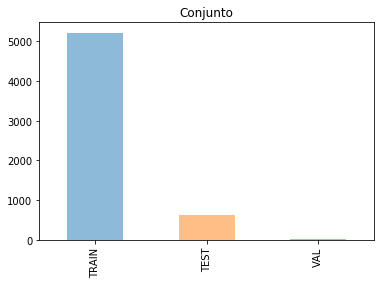

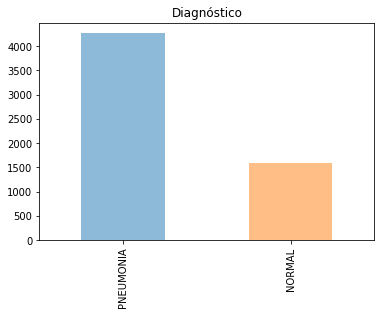

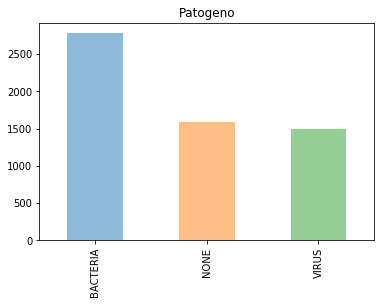

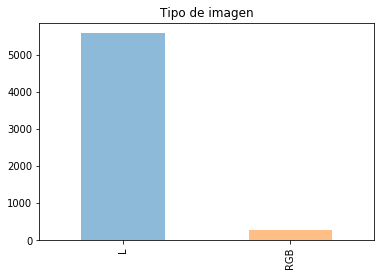

color        L  RGB
patogeno           
BACTERIA  2637  143
NONE      1583    0
VIRUS     1353  140


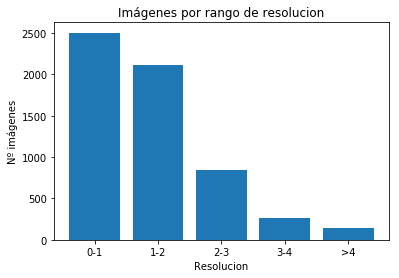

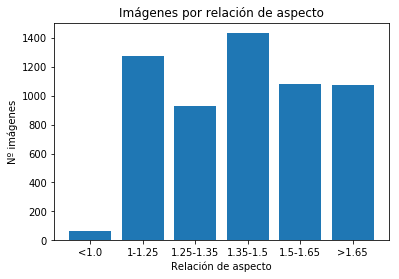

In [6]:
## ANALISIS ESTADISTICO

# Tabla cruzada de casos
tab = pd.crosstab(df_file['diagnostico'], df_file['patogeno'])
print(tab)

# Grafico de registros por conjunto
# Columna de conjunto
df_file['conjunto'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Conjunto")
plt.show()

# Grafico de registros por categoria
# Columna de diagnostico
df_file['diagnostico'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Diagnóstico")
plt.show()

# Columna de tipo infección
df_file['patogeno'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Patogeno")
plt.show()

# Tipo de imagen (codigos de Pil image.mode)
# 1 (1-bit pixels, black and white, stored with one pixel per byte)
# L (8-bit pixels, black and white)
# P (8-bit pixels, mapped to any other mode using a colour palette)
# RGB (3x8-bit pixels, true colour)
# RGBA (4x8-bit pixels, true colour with transparency mask)
# CMYK (4x8-bit pixels, colour separation)
# YCbCr (3x8-bit pixels, colour video format)
# I (32-bit signed integer pixels)
# F (32-bit floating point pixels)

# Columna de tipo imagen
df_file['color'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Tipo de imagen")
plt.show()

# Indago las imagenes que estan en color por el tipo infeccion
tab = pd.crosstab(df_file['patogeno'], df_file['color'])
print(tab)


## Análisis de imágenes por rango de resolucion

# Defino rangos de resolucion en MegaPixeles
rangos_resol = ['0-1', '1-2', '2-3', '3-4', '>4']

# Cuento el numero de registros en cada rango
reso1 = df_file[(df_file['res_Mpx'].astype(float)< 1.0)]['res_Mpx'].count()
reso2 = df_file[(df_file['res_Mpx'].astype(float)< 2.0)]['res_Mpx'].count() - reso1
reso3 = df_file[(df_file['res_Mpx'].astype(float)< 3.0)]['res_Mpx'].count() - reso2 - reso1
reso4 = df_file[(df_file['res_Mpx'].astype(float)< 4.0)]['res_Mpx'].count() - reso3 - reso2 - reso1
reso5 = df_file[(df_file['res_Mpx'].astype(float)>= 4.0)]['res_Mpx'].count()
# Creo lista de valores por rangos
resol = [reso1, reso2, reso3, reso4, reso5]

# Represento con gráfico de barras
plt.bar(rangos_resol, resol)
plt.xlabel("Resolucion")
plt.ylabel("Nº imágenes")
plt.title("Imágenes por rango de resolucion")
plt.show()


## Análisis de imágenes por relación de aspecto

# Defino rangos de resolucion en MegaPixeles
rangos_aspect = ['<1.0', '1-1.25', '1.25-1.35', '1.35-1.5', '1.5-1.65' , '>1.65']

# Cuento el numero de registros en cada rango
aspe1 = df_file[(df_file['rel_asp'].astype(float)< 1.0)]['rel_asp'].count()
aspe2 = df_file[(df_file['rel_asp'].astype(float)< 1.25)]['rel_asp'].count() - aspe1
aspe3 = df_file[(df_file['rel_asp'].astype(float)< 1.35)]['rel_asp'].count() - aspe2 - aspe1
aspe4 = df_file[(df_file['rel_asp'].astype(float)< 1.5)]['rel_asp'].count() - aspe3 - aspe2 - aspe1
aspe5 = df_file[(df_file['rel_asp'].astype(float)< 1.65)]['rel_asp'].count() - aspe4 - aspe3 - aspe2 - aspe1
aspe6 = df_file[(df_file['rel_asp'].astype(float)>= 1.65)]['rel_asp'].count()
# Creo lista de valores por rangos
aspect = [aspe1, aspe2, aspe3, aspe4, aspe5, aspe6]


# Represento con gráfico de barras
plt.bar(rangos_aspect, aspect)
plt.xlabel("Relación de aspecto")
plt.ylabel("Nº imágenes")
plt.title("Imágenes por relación de aspecto")
plt.show()

Muestra de imágenes con diagnóstico:
['./data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg', './data/chest_xray/test/NORMAL/IM-0001-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0003-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0005-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0006-0001.jpeg']


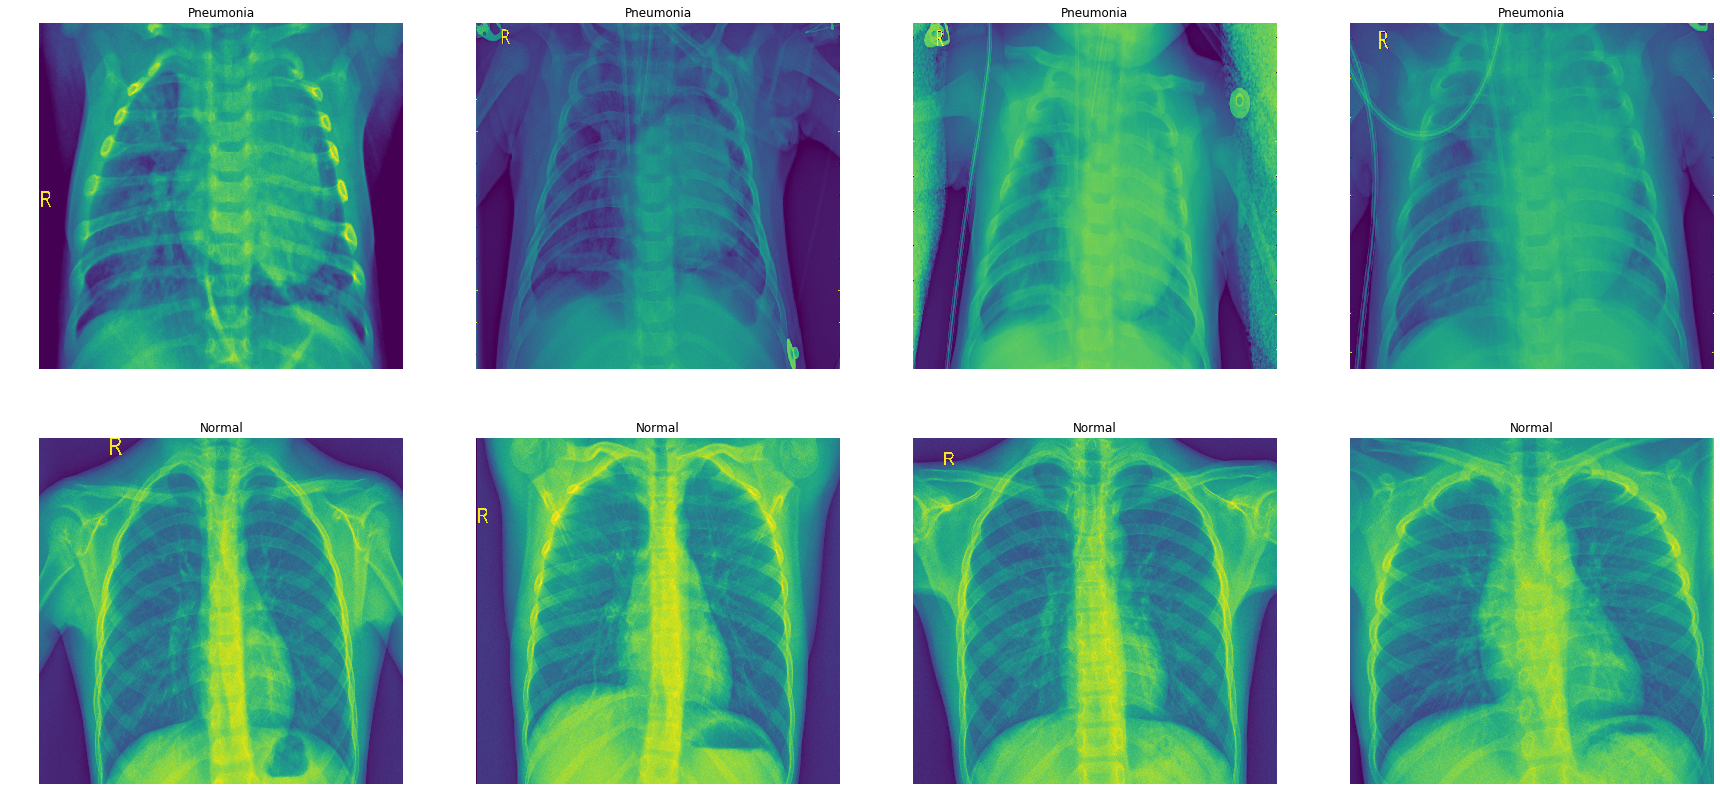


Muestra de imágenes por canales de color:


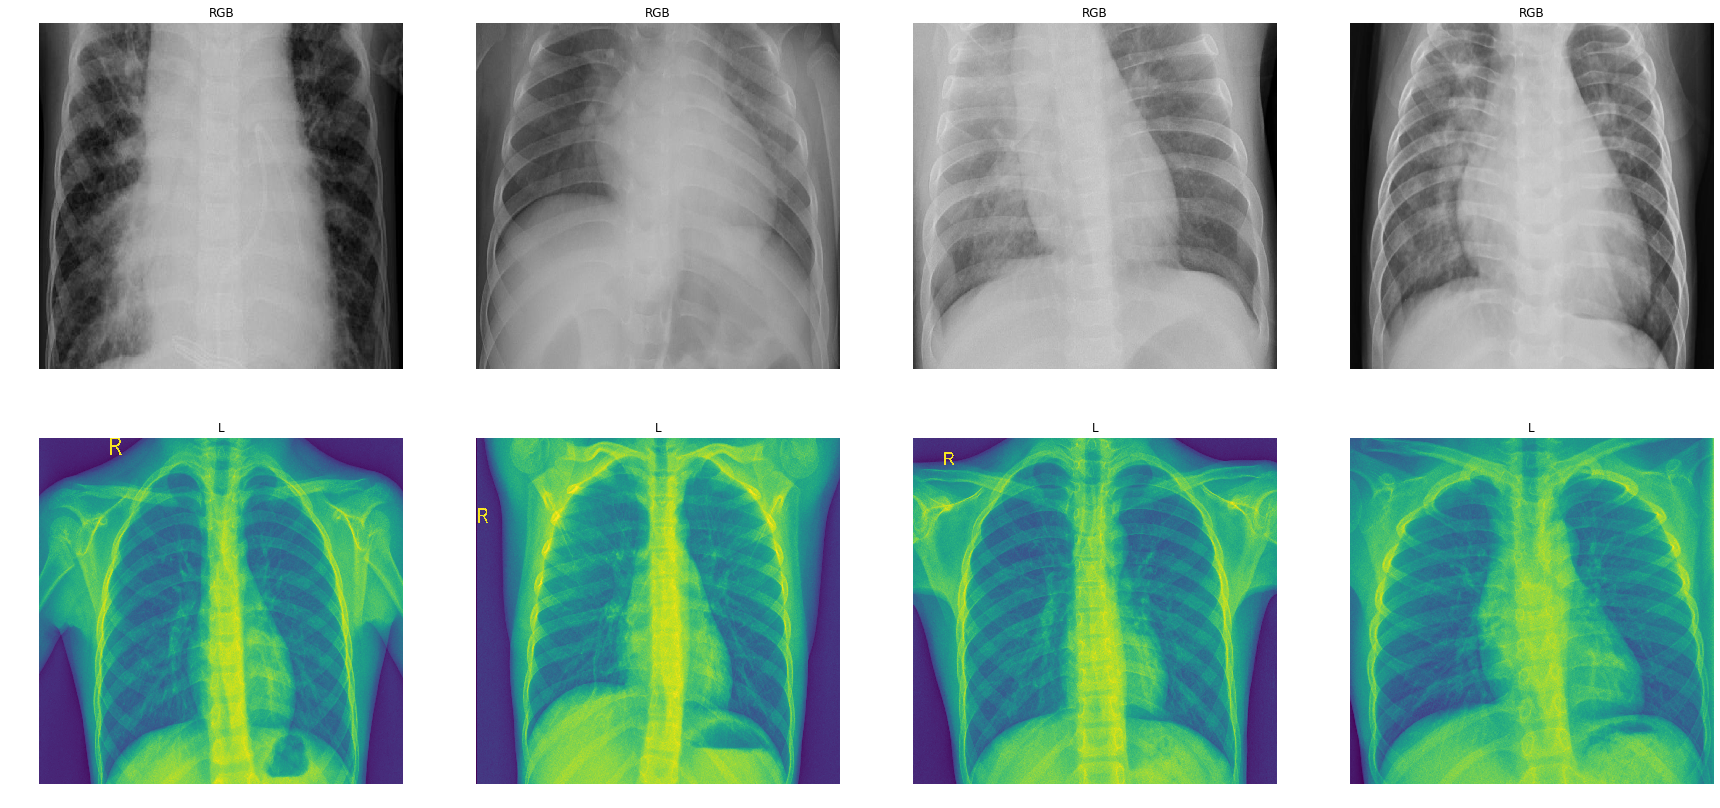

In [7]:
### MUESTRO ALGUNAS IMAGENES DE CADA 

print("Muestra de imágenes con diagnóstico:")

# Creo una lista con los 4 primeros registros de cada que hay en la tabla
pneumonia_samples = (df_file[df_file['diagnostico']=='PNEUMONIA']['fichero'].iloc[:4]).tolist()
normal_samples = (df_file[df_file['diagnostico']=='NORMAL']['fichero'].iloc[:4]).tolist()

# Unifico la lista
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

print(samples)

# Represento las imágenes en formato matriz
# Uso la función imread para accedere directamente con la ruta
from skimage.io import imread

# Creo lienzo de dibujo para la matriz de 2x4 = 8 elementos
f, ax = plt.subplots(2,4, figsize=(30,14))

for i in range(8):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img) #por si hubiese alguna en color
    # Añado rotulos con su procedencia
    if i<4:
        ax[i//4, i%4].set_title("Pneumonia")
    else:
        ax[i//4, i%4].set_title("Normal")
    # Elimino marcas de ejes
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()


print("\nMuestra de imágenes por canales de color:")

## Muestro tambien algunas imagenes en RGB
# Tomo los 4 primeros registros en RGB
RGB_samples = (df_file[df_file['color']=='RGB']['fichero'].iloc[:4]).tolist()
L_samples = (df_file[df_file['color']=='L']['fichero'].iloc[:4]).tolist()

color_samples = RGB_samples + L_samples
del RGB_samples, L_samples


# Creo lienzo de dibujo para la matriz de 2x4 = 8 elementos
f, ax = plt.subplots(2,4, figsize=(30,14))

for i in range(8):
    img = imread(color_samples[i])
    ax[i//4, i%4].imshow(img) #por si hubiese alguna en color
    # Añado rotulos con su procedencia
    if i<4:
        ax[i//4, i%4].set_title("RGB")
    else:
        ax[i//4, i%4].set_title("L")
    # Elimino marcas de ejes
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()


**Carga de datos**

Creo los conjuntos de datos cargando las imágenes de cada carpeta en una matriz de numpy. Comienzo por la carpeta de prueba (VAL), que es la que menor número de imágenes contiene. Durante la carga aprovecho para reescalar las imágenes a un tamaño homogéneo menor (150x150).

La primera prueba no es muy satisfactoria, así que pruebo otro método que incluye la conversión al estándar RGB y la normalización de los datos con funciones de la librería CV2, que resulta ser mucho más eficiente, por lo que lo aplico al resto de conjuntos, obteniendo economías de un orden de magnitud.

In [5]:
## Preparo conjuntos de datos

### Creo array con imagenes para modelo
# Creo listas con las rutas de las imágenes para cada conjunto
VAL_files = (df_file[df_file['conjunto']=='VAL']['fichero'].iloc[:]).tolist()

# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
VAL_labels = (df_file[df_file['conjunto']=='VAL']['diag_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_val = []
y_val = []


# Comienzo cargando los datos del conjunto de validacion por ser mas reducido
# Pruebo primero con resize de sckit-learn
print("Procesando dataset de datos:", len(VAL_labels),"elementos")

# Inicia cronometro
start_time = time.time()

for img in VAL_files:
    img = cv2.imread(str(img))
    img = resize(img, (150, 150, 3))
    img = np.asarray(img)
    X_val.append(img)

X_val = np.array(X_val)

# Continua cargando los datos de las etiquetas
for label in VAL_labels:
    y_val.append(label)

y_val = np.array(y_val)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_val.shape)
print(y_val.shape)

Procesando dataset de datos: 16 elementos
Este conjunto tardó en cargarse:  2.58 segundos ( 0.0 minutos)
(16, 150, 150, 3)
(16,)


In [8]:
## PRUEBA ALTERNATIVA PARA MEJORAR TIEMPO DE CARGA DE DATOS

# Creo listas con las rutas de las imágenes para cada conjunto
VAL_files = (df_file[df_file['conjunto']=='VAL']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
VAL_labels = (df_file[df_file['conjunto']=='VAL']['diag_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_val = []
y_val = []

# Comienzo cargando los datos del conjunto de validacion por ser mas reducido
print("Procesando dataset de datos:", len(VAL_labels),"elementos")

# Inicia cronometro
start_time = time.time()

for img in VAL_files:
    img = cv2.imread(str(img))
    # img = resize(img, (150, 150, 3))
    # Alternativamente
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Cambio del formato de entrada (orden BGR de OpenCV) al estandar (orden RGB)
    
    # Se puede probar con otros espacios de color
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Cambia de entrada (BGR OpenCV) a escala de grises 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Cambia de entrada (BGR OpenCV) a HSV (matiz, saturación, iluminancia)

    img = img.astype(np.float32)/255.0 # aprovecho para normalizar los datos. Se corresponde a la escala del espacio de color
    
    img = np.asarray(img)
    X_val.append(img)

X_val = np.array(X_val)

# Continua cargando los datos de las etiquetas
for label in VAL_labels:
    y_val.append(label)

y_val = np.array(y_val)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_val.shape)
print(y_val.shape)

Procesando dataset de datos: 16 elementos
Este conjunto tardó en cargarse:  0.31 segundos ( 0.0 minutos)
(16, 150, 150, 3)
(16,)


In [9]:
## OPTO POR EL SEGUNDO MÉTODO POR SER MUCHO MAS RAPIDO

# Continuo con dataset de entrenamiento


# Creo listas con las rutas de las imágenes para cada conjunto
TRAIN_files = (df_file[df_file['conjunto']=='TRAIN']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TRAIN_labels = (df_file[df_file['conjunto']=='TRAIN']['diag_ct'].iloc[:]).tolist()
# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_train = []
y_train = []

print("Procesando dataset de entrenamiento:", len(TRAIN_labels),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TRAIN_files:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_train.append(img)

X_train = np.array(X_train)

# Continua cargando los datos de las etiquetas
for label in TRAIN_labels:
    y_train.append(label)

y_train = np.array(y_train)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_train.shape)
print(y_train.shape)


# Termino con el dataset de prueba

# Creo listas con las rutas de las imágenes para cada conjunto
TEST_files = (df_file[df_file['conjunto']=='TEST']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TEST_labels = (df_file[df_file['conjunto']=='TEST']['diag_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_test = []
y_test = []

print("Procesando dataset de prueba:", len(TEST_labels),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TEST_files:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_test.append(img)

X_test = np.array(X_test)

# Continua cargando los datos de las etiquetas
for label in TEST_labels:
    y_test.append(label)

y_test = np.array(y_test)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_test.shape)
print(y_test.shape)

Procesando dataset de entrenamiento: 5216 elementos
Este conjunto tardó en cargarse:  62.36 segundos ( 1.0 minutos)
(5216, 150, 150, 3)
(5216,)
Procesando dataset de prueba: 624 elementos
Este conjunto tardó en cargarse:  6.56 segundos ( 0.1 minutos)
(624, 150, 150, 3)
(624,)


**Persistencia de datos**

Tras la optimización de la carga, pruebo a persistir en disco los arrays de numpy con las imágenes normalizadas como 
archivos csv, con el fin de tratar de reducir aún más los tiempos de futuros usos, pero no obtengo la eficiencia esperada.

In [17]:
### PRUEBO A GUARDAR LOS DATASET COMO CSV POR SI ACELERASE EL PROCESO DE CARGA Y RECUPERACION

# Lo pruebo con el conjunto de prueba (intermedio) 
# Guardo las matrices con libreria numpy en carpeta principal del dataset

# Inicia cronometro
start_time = time.time()

# En primer lugar hay que covertir el formato de 4D a "2D" para poder guardar el dataset
X_test_rsh = X_test.reshape(624, -1) # Tantas filas como archivos de imagenes hemos cargado, y columnas como se necesiten

print(X_test_rsh.shape)
print(X_test_rsh)

# Guardamos los datos con numpy
# Tardara un poco en ejecutar y requiere mucha memoria. Tambien al recuperar asi que no merece la pena
np.savetxt("./data/chest_xray/X_test_rsh.csv", X_test_rsh, delimiter=",")

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La grabacion en csv tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Con pandas tambien se podria guardar pero no como un array, por lo que posteriormente deberia tratarse
# Indico que no tiene cabecera. Ojo pandas agregara una columna de id al inicio que al recuperar debemos quitar
# X_train_rshpd = pd.DataFrame(X_train_rsh).to_csv('./data/chest_xray/X_train_rsh.csv')

(624, 67500)
[[0.14117648 0.14117648 0.14117648 ... 0.14117648 0.14117648 0.14117648]
 [0.13725491 0.13725491 0.13725491 ... 0.11764706 0.11764706 0.11764706]
 [0.14901961 0.14901961 0.14901961 ... 0.13333334 0.13333334 0.13333334]
 ...
 [0.08627451 0.08627451 0.08627451 ... 0.12941177 0.12941177 0.12941177]
 [0.8352941  0.8352941  0.8352941  ... 0.09019608 0.09019608 0.09019608]
 [0.04313726 0.04313726 0.04313726 ... 0.         0.         0.        ]]
La grabacion en csv tardó:  61.05 segundos ( 1.0 minutos)


In [8]:
## El guardado del array tarda mucho mas que la carga a partir de imagenes comprimidas
## Usar esta tecnica es inviable por el tamaño del csv (El conjunto de test es 1Gb y el entrenamiento 8,5Gb)
### Si queremos volver a cargarlos tambien tarda en pasarlo a ram porque son archivos muy grandes

# Inicia cronometro
start_time = time.time()

# Con numpy la carga seria
X_test_rsh = np.loadtxt('./data/chest_xray/X_test_rsh.csv', delimiter=',')

print(X_test_rsh.shape)

# Para volver a usarlos, al cargar deberemos restaurar su formato con
X_test_2 = X_test_rsh.reshape(624, 150, 150, 3) # Las dimensiones deben coincidir con las obtenidas antes
X_test_2 = X_test_2.astype('float32')

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La lectura desde csv tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

### Efectivamente podemos comprobarlo
print(X_test_2.shape)

# Con pandas la recarga seria (si se ha grabado como pandas)
# X_train_rsh = pd.read_csv('./data/chest_xray/X_train_rsh.csv')

# Y habria que convertirlo a numpy para seguir trabajando
# X_train_rsh = X_train_rsh.values

(624, 67500)
La lectura desde csv tardó:  51.89 segundos ( 0.9 minutos)
(624, 150, 150, 3)


**Prueba de modelos clásicos**

Comienzo probando algunos modelos clásicos de clasificación: SVM, árbol de decisión (simple y con AdaBoost).  
Previamente adapto el formato de las imágenes cargadas en los conjuntos a las dimensiones que requieren estos modelos.  
También realizo un análisis previo de componentes principales (PCA) para facilitar la clasificación.  
Finalmente obtengo las métricas de cada modelo. En el caso del árbol de decisión obtengo el número total de nodos y el de nodos finales para poder probar posteriormente un mapeo a perceptrón multicapa.

In [10]:
#### PRIMER MODELO CLASICO CON SVM

## PREPARACION FORMATO DEL CONJUNTO DE DATOS PARA MODELOS

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

###################################
### CONJUNTOS ESPECIFICOS PARA SVM
###################################


# Aseguro las dimensiones del array como imagenes de entrada para el modelo SVM
X_train_svm=X_train.reshape(5216,67500)
X_test_svm=X_test.reshape(624,67500)
X_val_svm=X_val.reshape(16,67500)

# Compruebo
print("Formato imagenes para entrada del modelo")
print(X_train_svm.shape)
print(X_test_svm.shape)
print(X_val_svm.shape)

# Compruebo
print("Formato etiquetas")
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Formato imagenes en conjuntos de carga
(5216, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo
(5216, 67500)
(624, 67500)
(16, 67500)
Formato etiquetas
(5216,)
(624,)
(16,)


In [11]:
# #############################################################################
## ANALISIS DE COMPONENTES PRINCIPALES PCA


from sklearn.decomposition import PCA

n_components = 150

print("\nExtrae los %d eigenfaces principales de %d datos" % (n_components, X_train_svm.shape[0]))

# Inicia cronometro
start_time = time.time()

# Define modelo PCA de n_componentes y lo entrena
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_svm)

print("Dimensiones matriz pca generada:", pca.components_.shape)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La reduccion PCA tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")


Extrae los 150 eigenfaces principales de 5216 datos
Dimensiones matriz pca generada: (150, 67500)
La reduccion PCA tardo:  8.83 segundos ( 0.1 minutos)


In [12]:
print("\nProyectando los datos de entrada sobre la base ortonormal de los eigenfaces")

# Inicia cronometro
start_time = time.time()

X_train_pca = pca.transform(X_train_svm)
X_test_pca = pca.transform(X_test_svm)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La proyeccion ortonormal de los datos tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")

print(X_train_pca.shape)
print(X_test_pca.shape)


Proyectando los datos de entrada sobre la base ortonormal de los eigenfaces
La proyeccion ortonormal de los datos tardo:  1.3 segundos ( 0.0 minutos)
(5216, 150)
(624, 150)


In [10]:
# #############################################################################
# Entreno un clasificador SVM tuneandolo para los mejores parametros

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("\nProbando el clasificador SVM con el conjunto de entrenamiento")

# Inicia cronometro
start_time = time.time()

# Defino un diccionario de parametros para probar (SVM tuneado)
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

# Defino un modelo SVM con kernel rbf
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)

# Modelo de entrenamiento
clf = clf.fit(X_train_pca, y_train)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del SVM tuneado ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")

print("\nParametros del mejor estimador encontrado en la busqueda")
print(clf.best_estimator_)


Probando el clasificador SVM con el conjunto de entrenamiento
El entrenamiento del SVM tuneado ha tardado:  375.05 segundos ( 6.3 minutos)

Parametros del mejor estimador encontrado en la busqueda
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [11]:
# #############################################################################
# Pruebo el modelo con el conjunto de datos de prueba

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("\nPrediciendo los nombres de las personas en el conjunto de prueba")

# Inicia cronometro
start_time = time.time()

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred = clf.predict(X_test_pca)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La prediccion con el modelo SVM tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Informe de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de confusion para el conjunto de prueba:\n")
print(confusion_matrix(y_test, y_pred))


Prediciendo los nombres de las personas en el conjunto de prueba
La prediccion con el modelo SVM tarda:  0.17 segundos ( 0.0 minutos)

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

      NORMAL       0.97      0.31      0.47       234
   PNEUMONIA       0.71      0.99      0.83       390

   micro avg       0.74      0.74      0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624


Matriz de confusion para el conjunto de prueba:

[[ 72 162]
 [  2 388]]


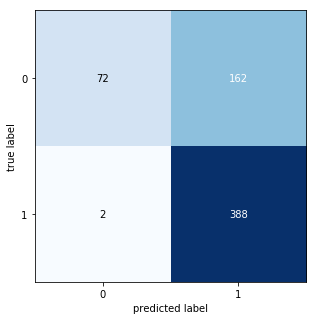

In [12]:
# Libreria mlxtend para dibujo con diseño de la matriz de confusion
CM = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [1]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

# precisión = verdadero positivo/(verdadero positivo + falso positivo)

# (fila 1, columna 1) = 387; fila 0, columna 1) = 70
print ("Precision: ", round(388 / (388 + 162), 3))

# La precisión no se puede tomar como solo métrica porque las clases de entrada estan descompensadas
# Es mas importante la recuperación porque queremos minimizar falso negativos

# RECALL = verdadero positivo/(verdadero positivo + falso negativo)

# (fila 1, columna 1) = 387; fila 1, columna 0) = 3
print("Recall: ", round(388 / (388 + 2), 3))

Precision:  0.705
Recall:  0.995


In [13]:
# Indice de JACARD

from sklearn.metrics import jaccard_similarity_score

print("jaccard_similarity_score: ", round(jaccard_similarity_score(y_test, y_pred),3))

jaccard_similarity_score:  0.737


In [13]:
# #############################################################################
# Entreno un clasificador ARBOL DE DECISION

from sklearn.tree import DecisionTreeClassifier

print("\nProbando el clasificador ARBOL DE DECISION con el conjunto de entrenamiento")

# Inicia cronometro
start_time = time.time()


# Defino un modelo ARBOL DE DECISION con criterio gini (es un clasificador)
clf_AD = DecisionTreeClassifier(criterion = 'gini', random_state = 0, max_depth=10, min_samples_split=3)

# Modelo de entrenamiento
clf_AD = clf_AD.fit(X_train_pca, y_train)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del ARBOL DE DECISION ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")


Probando el clasificador ARBOL DE DECISION con el conjunto de entrenamiento
El entrenamiento del ARBOL DE DECISION ha tardado:  0.52 segundos ( 0.0 minutos)


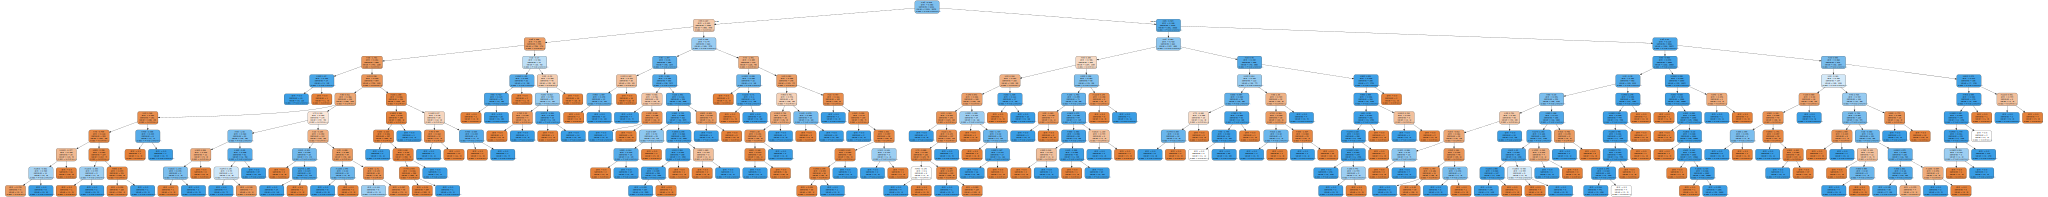

In [14]:
# Creo grafico con el diagrama del arbol de decision
import graphviz 
from sklearn import tree

# Configuro el grafico
dot_data = tree.export_graphviz(clf_AD, out_file=None, class_names=['NORMAL','PNEUMONIA'], filled=True, 
                                rounded=True, special_characters=True) 

# Genero el grafico
graph = graphviz.Source(dot_data) 

# Salida del grafico
graph.render("Arbol Decision") # Grabo el arbol en un archivo pdf con el nombre especificado
graph # Lo represento en pantalla

In [15]:
##########################
# RECUENTO DE NODOS Y NODOS FINALES

print("Numero de nodos del arbol: ", clf_AD.tree_.node_count)


# Utilizo matrices para almacenar la estructura de conexiones del arbol de decision
n_nodes = clf_AD.tree_.node_count
children_left = clf_AD.tree_.children_left
children_right = clf_AD.tree_.children_right

# Matrices para almacenar la profundidad de cada nodo y si es final
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

# Semilla para el nodo inicial
stack = [(0, -1)]

# Variable para contar el numero de nodos finales
final_node = 0

# Bucle de comparacion que recorre cada nivel del arbol
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # Si el nodo es de test se incrementa el nivel
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    # Si no el nodo es final y se incrementa el contador
    else:
        is_leaves[node_id] = True
        final_node = final_node + 1

print("Nodos finales: ", final_node)

Numero de nodos del arbol:  333
Nodos finales:  167


In [16]:
# #############################################################################
# Pruebo el modelo con el conjunto de datos de prueba

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("\nPrediciendo con Arbol de Decisión en el conjunto de prueba")

# Inicia cronometro
start_time = time.time()

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred = clf_AD.predict(X_test_pca)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La prediccion con el modelo AD tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Informe de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de confusion para el conjunto de prueba:\n")
print(confusion_matrix(y_test, y_pred))

print('\nPrecisión modelo conjunto train: ', round(clf_AD.score(X_train_pca, y_train), 3))
print('Precisión modelo conjunto test: ', round(clf_AD.score(X_test_pca, y_test),3))


Prediciendo con Arbol de Decisión en el conjunto de prueba
La prediccion con el modelo AD tarda:  0.0 segundos ( 0.0 minutos)

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

      NORMAL       0.75      0.40      0.52       234
   PNEUMONIA       0.72      0.92      0.81       390

   micro avg       0.73      0.73      0.73       624
   macro avg       0.74      0.66      0.67       624
weighted avg       0.73      0.73      0.70       624


Matriz de confusion para el conjunto de prueba:

[[ 94 140]
 [ 31 359]]

Precisión modelo conjunto train:  0.987
Precisión modelo conjunto test:  0.726


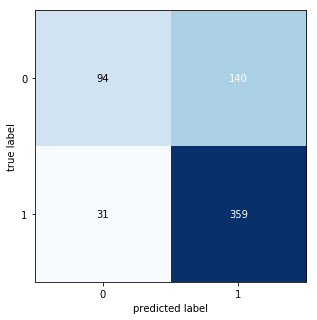

In [17]:
# Libreria mlxtend para dibujo con diseño de la matriz de confusion
CM = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [18]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

# precisión = verdadero positivo/(verdadero positivo + falso positivo)

# (fila 1, columna 1) = 359; fila 0, columna 1) = 140
print ("Precision: ", round(359 / (359 + 140), 3))

# La precisión no se puede tomar como solo métrica porque las clases de entrada estan descompensadas
# Es mas importante la recuperación porque queremos minimizar falso negativos

# RECALL = verdadero positivo/(verdadero positivo + falso negativo)

# (fila 1, columna 1) = 361; fila 1, columna 0) = 29
print("Recall: ", round(359 / (359 + 31), 3))

Precision:  0.719
Recall:  0.921


In [19]:
# Indice de JACARD

from sklearn.metrics import jaccard_similarity_score

print("jaccard_similarity_score: ", round(jaccard_similarity_score(y_test, y_pred),3))

jaccard_similarity_score:  0.726


In [20]:
# #############################################################################
# Entreno un clasificador ADA BOOST

from sklearn.ensemble import AdaBoostClassifier

print("\nProbando el clasificador ARBOL DE DECISION con el conjunto de entrenamiento")

# Inicia cronometro
start_time = time.time()


# Defino un modelo ADA BOOST con base en el arbol de decision
clf_ADA = AdaBoostClassifier(base_estimator=clf_AD, n_estimators=95, learning_rate=1.71, random_state=1)


# Modelo de entrenamiento
clf_ADA = clf_ADA.fit(X_train_pca, y_train)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del ADA BOOST ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")


Probando el clasificador ARBOL DE DECISION con el conjunto de entrenamiento
El entrenamiento del ADA BOOST ha tardado:  29.98 segundos ( 0.5 minutos)


In [21]:
# Utilizando AdaBoost para tratar de aumentar la precisión

# #############################################################################
# Pruebo el modelo con el conjunto de datos de prueba

print("\nPrediciendo con AdaBoost")

# Inicia cronometro
start_time = time.time()

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred = clf_ADA.predict(X_test_pca)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La prediccion con el modelo AD tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Informe de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de confusion para el conjunto de prueba:\n")
print(confusion_matrix(y_test, y_pred))

print('\nPrecisión modelo conjunto train: ', round(clf_ADA.score(X_train_pca, y_train), 3))
print('Precisión modelo conjunto test: ', round(clf_ADA.score(X_test_pca, y_test),3))


Prediciendo con AdaBoost
La prediccion con el modelo AD tarda:  0.02 segundos ( 0.0 minutos)

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

      NORMAL       0.90      0.41      0.56       234
   PNEUMONIA       0.73      0.97      0.83       390

   micro avg       0.76      0.76      0.76       624
   macro avg       0.81      0.69      0.70       624
weighted avg       0.79      0.76      0.73       624


Matriz de confusion para el conjunto de prueba:

[[ 95 139]
 [ 11 379]]

Precisión modelo conjunto train:  1.0
Precisión modelo conjunto test:  0.76


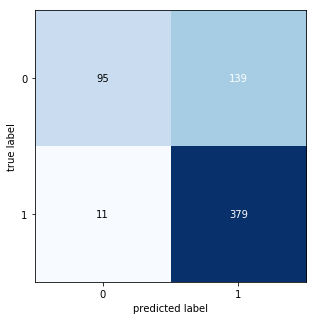

In [22]:
# Libreria mlxtend para dibujo con diseño de la matriz de confusion
CM = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [23]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

# precisión = verdadero positivo/(verdadero positivo + falso positivo)

# (fila 1, columna 1) = 361; fila 0, columna 1) = 85
print ("Precision: ", round(379 / (379 + 139), 3))

# La precisión no se puede tomar como solo métrica porque las clases de entrada estan descompensadas
# Es mas importante la recuperación porque queremos minimizar falso negativos

# RECALL = verdadero positivo/(verdadero positivo + falso negativo)

# (fila 1, columna 1) = 361; fila 1, columna 0) = 29
print("Recall: ", round(379 / (379 + 11), 3))

Precision:  0.732
Recall:  0.972


In [24]:
# Indice de JACARD

from sklearn.metrics import jaccard_similarity_score

print("jaccard_similarity_score: ", round(jaccard_similarity_score(y_test, y_pred),3))

jaccard_similarity_score:  0.76


**Modelos de aprendizaje profundo**

Comienzo con una red neuronal que pretende emular un perceptrón multicapa mapeando la clasificación realizada con el 
modelo de árbol de decisión. Es una prueba más teórica que práctica, muy ineficiente en tiempo y capacidad, pero que
me ha parecido interesnte realizar.  
A continuación preparo el formato para los modelos de redes convolucionales. Pruebo una básica y otra separable, con
un número de iteraciones muy reducido simplemente para verificar cual será lamejor estrategia en adelante.  
Continúo obteniendo las métricas de cada modelo probado.

In [25]:
######################################################
## MODELO DE PERCEPTRON MULTICAPA

# Carga de librerias y funciones de Keras para modelos RN
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras import optimizers



# Habilitamos funciones de llamada interna de keras para monitorizar el proceso durante el entrenamiento
# Y para reducir la tasa de aprendizaje ReduceLROnPlateau cuando cerca de minimo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

Using TensorFlow backend.
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [26]:
####################################################
# Definicion de perceptron multicapa
# Aplico las reglas de conversion del arbol de decision en un perceptron multicapa

perceptron_multi = Sequential()
# Introduzco datos con Flatten
perceptron_multi.add(keras.layers.Flatten(input_shape=(150,150,3)))
# Nº neuronas primera capa oculta = nº nodos arbol decision
perceptron_multi.add(keras.layers.Dense (n_nodes,activation='sigmoid'))
# Nº neuronas segunda capa oculta = nº nodos finales arbol de decision
perceptron_multi.add(keras.layers.Dense (final_node,activation='sigmoid'))
# Tras el aprendizaje de los detalles, incluyo el clasificador con dense
perceptron_multi.add(keras.layers.Dense (1,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# Definición de optimizador
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
perceptron_multi.compile(optimizer = 'sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Muestra arquitectura de la red antes de entrenar el modelo
print(perceptron_multi.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 333)               22477833  
_________________________________________________________________
dense_2 (Dense)              (None, 167)               55778     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 168       
Total params: 22,533,779
Trainable params: 22,533,779
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
## ENTRENAMIENTO MODELO PERCEPTRON MULTICAPA

# Parametros de entrenamiento
batch_size = 1024
epochs = 1

#### PONER AQUI EL CHECKPOINT PARA REDEFINIR FILEPATH EN CADA MODELO!!!!!!

# Habilito una ruta y un archivo para guardar los pesos de entrenamiento de la red

## ESPECIFICO PARA ESTA RED
filepath="./checkpoints/chest_xray_weights_perceptron.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Entrenamiento del modelo

# Inicia cronometro
start_time = time.time()

history_perceptr = perceptron_multi.fit(X_train, y_train, validation_data = (X_test , y_test), callbacks=[lr_reduce,checkpoint], epochs=epochs)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 624 samples
Epoch 1/1
5216/5216 [==============================] - 20s 4ms/step - loss: 4.0987 - acc: 0.7429 - val_loss: 5.9784 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to ./checkpoints/chest_xray_weights_perceptron.hdf5
El entrenamiento de este modelo tardó:  20.68 segundos ( 0.3 minutos)


In [29]:
# Definimos variables para guardar los resultados del modelo de referencia entrenado
print("Precision acc: ", history_perceptr.history['acc'])
print("Precision en prueba val_acc: ", history_perceptr.history['val_acc'])
print("Perdida loss: ", history_perceptr.history['loss'])
print("Perdida en prueba val_loss: ", history_perceptr.history['val_loss'])

Precision acc:  [0.7429064417177914]
Precision en prueba val_acc:  [0.625]
Perdida loss:  [4.098684615518418]
Perdida en prueba val_loss:  [5.978394358586067]


In [30]:
#############################################################################
## PREPARACION FORMATO DEL CONJUNTO DE DATOS PARA MODELOS DE REDES NEURONALES CONVOLUCIONADAS

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Aseguro las dimensiones del array como imagenes de entrada para el modelo
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)
X_val=X_val.reshape(16,3,150,150)

# Compruebo
print("Formato imagenes para entrada del modelo")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Compruebo
print("Formato etiquetas")
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Formato imagenes en conjuntos de carga
(5216, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo
(5216, 3, 150, 150)
(624, 3, 150, 150)
(16, 3, 150, 150)
Formato etiquetas
(5216,)
(624,)
(16,)


In [31]:
# Convierto los conjuntos de datos en los array de etiquetas a categoricos
# Uso 2 clases (clasificacion binaria) porque el campo diagnostico tiene 2 valores. Si patogeno, 3.

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=2, dtype='int') # Solo toma numeros, por defecto enteros
y_test = to_categorical(y_test, num_classes=2, dtype='int')
y_val =  to_categorical(y_val, num_classes=2, dtype='int')

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216, 2)
(624, 2)
(16, 2)


In [32]:
# Carga de librerias y funciones de Keras para modelos RN
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import Input, SeparableConv2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


# Habilitamos funciones de llamada interna de keras para monitorizar el proceso durante el entrenamiento
# Y para reducir la tasa de aprendizaje ReduceLROnPlateau cuando cerca de minimo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [33]:
# Definicion de un modelo base de referencia

# Aprendo detalles en bloques mediante 2 convolucionales y un maxpooling para reducir datos
# Repito la estrategia 3 veces incrementando el numero de filtros cada vez, en orden binario, concentrando detalles
# Tras el aprendizaje de los detalles, incluyo formateador con Flatten y el clasificador con dense

model_referencia = Sequential()

# Fuerzo de nuevo el formato de entrada original pese al procesado anterior
model_referencia.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model_referencia.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model_referencia.add(MaxPooling2D(pool_size=(2, 2)))

model_referencia.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_referencia.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model_referencia.add(MaxPooling2D(pool_size=(2, 2)))

model_referencia.add(Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model_referencia.add(Conv2D(64, (3, 3), padding="valid", activation='relu'))
model_referencia.add(MaxPooling2D(pool_size=(2, 2)))

# Formateo de datos con Flatten
model_referencia.add(Flatten())

# Clasificador con capas totalmente conectadas

model_referencia.add(Dense(64, activation='relu'))
model_referencia.add(Dropout(0.4))
model_referencia.add(Dense(2 , activation='sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
# Compilacion
# Uso binary_crossentropy porque es una clasificación de 2 clases excluyentes.
# Para el modelo con 3 clases debería usar categorical_crossentropy
# model_referencia.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.00005), metrics=['accuracy'])
model_referencia.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0005), metrics=['accuracy'])


# Keras cambia la forma de calculo de la funcion de perdida y afecta a la metrica !!!!
# https://stackoverflow.com/questions/41327601/why-is-binary-crossentropy-more-accurate-than-categorical-crossentropy-for-multi

# Resumen del modelo
print(model_referencia.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)        18496     
__________

In [35]:
## ENTRENAMIENTO MODELO RN CONVOLUCIONAL DE REFERENCIA

# Parametros de entrenamiento
batch_size = 256
epochs = 4


# Habilito una ruta y un archivo para guardar los pesos de entrenamiento de la red
## ESPECIFICO PARA ESTA RED
filepath="./checkpoints/chest_xray_weights_ref.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Entrenamiento del modelo
# Inicia cronometro
start_time = time.time()

history_referencia = model_referencia.fit(X_train, y_train, validation_data = (X_test , y_test), callbacks=[lr_reduce,checkpoint], epochs=epochs)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")


Train on 5216 samples, validate on 624 samples
Epoch 1/4
5216/5216 [==============================] - 146s 28ms/step - loss: 0.4244 - acc: 0.8075 - val_loss: 0.9286 - val_acc: 0.7107

Epoch 00001: val_acc improved from -inf to 0.71074, saving model to ./checkpoints/chest_xray_weights_ref.hdf5
Epoch 2/4
5216/5216 [==============================] - 146s 28ms/step - loss: 0.2532 - acc: 0.8997 - val_loss: 0.7224 - val_acc: 0.7332

Epoch 00002: val_acc improved from 0.71074 to 0.73317, saving model to ./checkpoints/chest_xray_weights_ref.hdf5
Epoch 3/4
5216/5216 [==============================] - 147s 28ms/step - loss: 0.1919 - acc: 0.9254 - val_loss: 0.8661 - val_acc: 0.7508

Epoch 00003: val_acc improved from 0.73317 to 0.75080, saving model to ./checkpoints/chest_xray_weights_ref.hdf5
Epoch 4/4
5216/5216 [==============================] - 145s 28ms/step - loss: 0.1794 - acc: 0.9378 - val_loss: 0.8115 - val_acc: 0.7316

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.0000002374

In [36]:
# Definimos variables para guardar los resultados del modelo de referencia entrenado
acc_ref = history_referencia.history['acc']
val_acc_ref = history_referencia.history['val_acc']
loss_ref = history_referencia.history['loss']
val_loss_ref = history_referencia.history['val_loss']


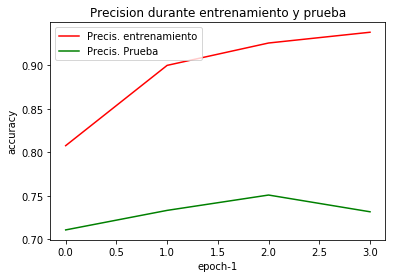

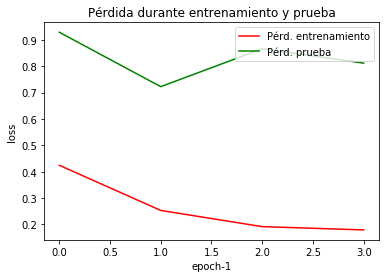

<Figure size 432x288 with 0 Axes>

In [37]:
# Representacion de metricas para el modelo de referenia durante el entrenamiento

# Precision
plt.plot(acc_ref, label='Precis. entrenamiento', color='Red')
plt.plot(val_acc_ref, label='Precis. Prueba', color='Green')
plt.title('Precision durante entrenamiento y prueba')
plt.ylabel('accuracy')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper left')
plt.figure()

# Perdida
plt.plot(loss_ref, label='Pérd. entrenamiento', color='Red')
plt.plot(val_loss_ref, label='Pérd. prueba', color='Green')
plt.title('Pérdida durante entrenamiento y prueba')
plt.ylabel('loss')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper right')
plt.figure()

# Represento
plt.show()

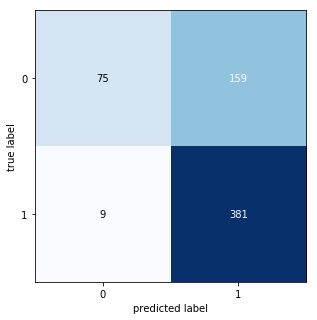

In [38]:
from sklearn.metrics import confusion_matrix
pred = model_referencia.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

# Libreria mlxtend para dibujo rapido de la matriz
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [39]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

# precisión = verdadero positivo/(verdadero positivo + falso positivo)

# (fila 1, columna 1) = 378; fila 0, columna 1) = 174
print ("Precision: ", round(381 / (381 + 159), 3))

# La precisión no se puede tomar como solo métrica porque las clases de entrada estan descompensadas
# Es mas importante la recuperación porque queremos minimizar falso negativos

# RECALL = verdadero positivo/(verdadero positivo + falso negativo)

# (fila 1, columna 1) = 378; fila 1, columna 0) = 12
print("Recall: ", round(381 / (381 + 9), 3))

Precision:  0.706
Recall:  0.977


In [41]:
####################################################
# Definicion de modelo_base

# Introduzco datos con una convolucional y reduzco con maxpooling
# Aplico convoluciones separables en profundidad para aprender detalles estirando canales
# Para reducir numero de parametros y acelerar calculos simplificando arquitectura y reduciendo sobreajuste
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

# Repito la estrategia 3 veces incrementando el numero de filtros cada vez para concentrar detalles
# Uso normalización en las dos ultimas

# Tras el aprendizaje de los detalles, incluyo formateador con Flatten y el clasificador con dense

model_basico = Sequential()
model_basico.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model_basico.add(MaxPooling2D(pool_size=(2, 2)))

model_basico.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico.add(MaxPooling2D(pool_size=(2, 2)))

model_basico.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico.add(BatchNormalization())
model_basico.add(MaxPooling2D(pool_size=(2, 2)))

model_basico.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
model_basico.add(BatchNormalization())
model_basico.add(MaxPooling2D(pool_size=(2, 2)))

# Formateo de datos con Flatten
model_basico.add(Flatten())

# Clasificador con capas totalmente conectadas
model_basico.add(Dense(64, activation='relu')) # Capa con funcion de activacion tuneada
model_basico.add(Dropout(0.4))
model_basico.add(Dense(2 , activation='softmax'))


In [42]:
# Compilacion
# Uso binary_crossentropy porque es una clasificación de 2 clases excluyentes.
# Para el modelo con 3 clases debería usar categorical_crossentropy
model_basico.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-5), metrics=['accuracy'])

# Keras cambia la forma de calculo de la funcion de perdida y afecta a la metrica !!!!
# https://stackoverflow.com/questions/41327601/why-is-binary-crossentropy-more-accurate-than-categorical-crossentropy-for-multi

# Resumen del modelo
print(model_basico.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 150, 150)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 75, 75)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 64, 75, 75)        4736      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 37, 37)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 64, 37, 37)        4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 37, 37)        148       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 18, 18)        0         
__________

In [50]:
## ENTRENAMIENTO MODELO RN CONVOLUCIONAL SEPARABLE BASICO

# Parametros de entrenamiento
batch_size = 256
epochs = 4

# Habilito una ruta y un archivo para guardar los pesos de entrenamiento de la red
## ESPECIFICO PARA ESTA RED
filepath="./checkpoints/chest_xray_weights_basico.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Entrenamiento del modelo
# Inicia cronometro
start_time = time.time()

history_basico = model_basico.fit(X_train, y_train, validation_data = (X_test , y_test), callbacks=[lr_reduce,checkpoint], epochs=epochs)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

Train on 5216 samples, validate on 624 samples
Epoch 1/4
5216/5216 [==============================] - 164s 32ms/step - loss: 0.3347 - acc: 0.8556 - val_loss: 0.6987 - val_acc: 0.6987

Epoch 00001: val_acc improved from -inf to 0.69872, saving model to ./checkpoints/chest_xray_weights_basico.hdf5
Epoch 2/4
5216/5216 [==============================] - 162s 31ms/step - loss: 0.1634 - acc: 0.9369 - val_loss: 0.6502 - val_acc: 0.7580

Epoch 00002: val_acc improved from 0.69872 to 0.75801, saving model to ./checkpoints/chest_xray_weights_basico.hdf5
Epoch 3/4
5216/5216 [==============================] - 163s 31ms/step - loss: 0.1301 - acc: 0.9546 - val_loss: 0.8393 - val_acc: 0.7388

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00003: val_acc did not improve from 0.75801
Epoch 4/4
5216/5216 [==============================] - 164s 32ms/step - loss: 0.1032 - acc: 0.9638 - val_loss: 0.7814 - val_acc: 0.7644

Epoch 00004: val_acc improved from 0.75801 to

In [51]:
# Definimos variables para guardar los resultados del modelo de referencia entrenado
acc_bas = history_basico.history['acc']
val_acc_bas = history_basico.history['val_acc']
loss_bas = history_basico.history['loss']
val_loss_bas = history_basico.history['val_loss']


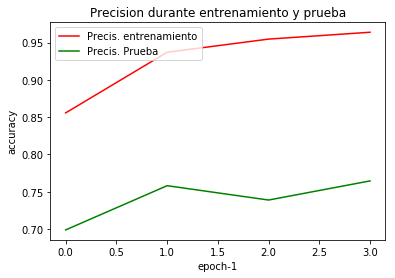

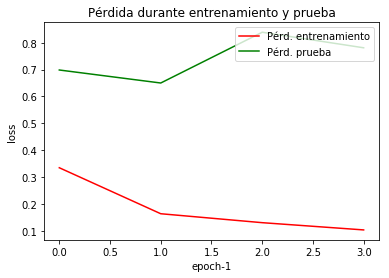

<Figure size 432x288 with 0 Axes>

In [52]:
# Representacion de metricas para el modelo de referenia durante el entrenamiento

# Precision
plt.plot(acc_bas, label='Precis. entrenamiento', color='Red')
plt.plot(val_acc_bas, label='Precis. Prueba', color='Green')
plt.title('Precision durante entrenamiento y prueba')
plt.ylabel('accuracy')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper left')
plt.figure()

# Perdida
plt.plot(loss_bas, label='Pérd. entrenamiento', color='Red')
plt.plot(val_loss_bas, label='Pérd. prueba', color='Green')
plt.title('Pérdida durante entrenamiento y prueba')
plt.ylabel('loss')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper right')
plt.figure()

# Represento
plt.show()

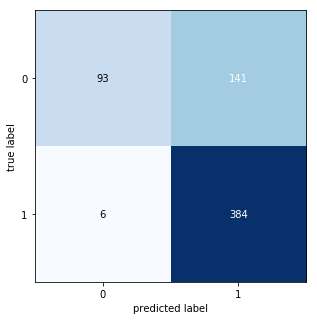

In [53]:
pred = model_basico.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

# Libreria mlxtend para dibujo rapido de la matriz
CM = confusion_matrix(y_true, pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [54]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

# precisión = verdadero positivo/(verdadero positivo + falso positivo)

# (fila 1, columna 1) = 361; fila 0, columna 1) = 85
print ("Precision: ", round(384 / (384 + 141), 3))

# La precisión no se puede tomar como solo métrica porque las clases de entrada estan descompensadas
# Es mas importante la recuperación porque queremos minimizar falso negativos

# RECALL = verdadero positivo/(verdadero positivo + falso negativo)

# (fila 1, columna 1) = 361; fila 1, columna 0) = 29
print("Recall: ", round(384 / (384 + 6), 3))

Precision:  0.731
Recall:  0.985
